## Spam/Ham Classifier

This model aims to predict whether an email is spam or not spam (ham). The dataset consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

The dataset contains four columns:
1. `id`: An identifier for the training example
2. `subject`: The subject of the email
3. `email`: The text of the email
4. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/email-data/train.csv
/kaggle/input/email-data/test.csv


## Loading the Data

In [2]:
original_training_data = pd.read_csv('../input/email-data/train.csv')
test = pd.read_csv('../input/email-data/test.csv')

# Converting the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Cleaning null values

In [3]:
nulls = original_training_data[original_training_data['subject'].isnull() | original_training_data['email'].isnull()]
print('Null values:', len(nulls))

# Replacing null values with empty strings
original_training_data = original_training_data.fillna('')
new_nulls = original_training_data[original_training_data['subject'].isnull() | original_training_data['email'].isnull()]
print('Null values:', len(new_nulls))

Null values: 6
Null values: 0


Printing the first ham and first spam emails to identify any initial differences.

In [4]:
hams = original_training_data[original_training_data['spam'] == 0]
spams = original_training_data[original_training_data['spam'] == 1]

first_ham = hams['email'].iloc[0]
first_spam = spams['email'].iloc[0]
print('First Ham Email')
print(first_ham)
print('First Spam Email')
print(first_spam)

First Ham Email
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

First Spam Email
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



By looking at the first ham and spam emails, the spam email has HTML tags unlike the ham email. The ham email also has a greeting for a specificf person at the end of the email ("thanks, misha").

### Training Validation Split

In [5]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

## Basic Feature Engineering

Creating a function that takes in a list of words and a pandas Series of email texts, outputting a 2-dimensional NumPy array containing one row for each email text: the row should contain either a 0 or a 1 for each word in the list, where it is 0 if the word doesn't appear in the text and 1 if the word does.

In [6]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings gto search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = [int(word in text) for text in texts for word in words]
    indicator_array = np.array_split(np.array(indicator_array), len(texts))
    return np.array(indicator_array)
    
words_in_texts(['hello', 'bye', 'world'], ['hello', 'hello worldhello'])

array([[1, 0, 0],
       [1, 0, 1]])

## Basic Exploratory Data Analysis
Finding features for distinguishing spam emails from ham emails by comparing distributions.

#### A bar chart comparing the proportion of spam and ham emails containing certain words that have different proportions for the two classes.

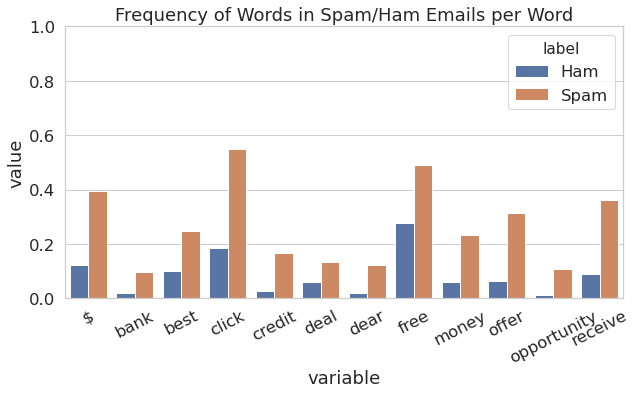

In [7]:
# Preserve ordering of labels
train=train.reset_index(drop=True)

# Selected words to distinguish between spam and ham emails
words = ['free', 'credit', 'offer', '$', 'money', 'click', 'opportunity', 'bank', 'receive', 'dear', 'best', 'deal']

# Finding the proportions of spam and ham emails per word
contains = words_in_texts(words, train['email'])
contains = pd.DataFrame(data=contains, columns=words)
contains['label'] = train['spam']
contains['label'] = contains['label'].replace(0, 'Ham').replace(1, 'Spam')
contains = contains.melt('label')
contains = contains.groupby(['label', 'variable']).mean().reset_index()
contains

plt.figure(figsize=(10,5)) 
sns.barplot(x=contains['variable'], y=contains['value'], hue=contains['label'])
plt.title('Frequency of Words in Spam/Ham Emails per Word')
plt.ylim(0,1)
plt.xticks(rotation=27);

#### A class conditional density plot, comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set.

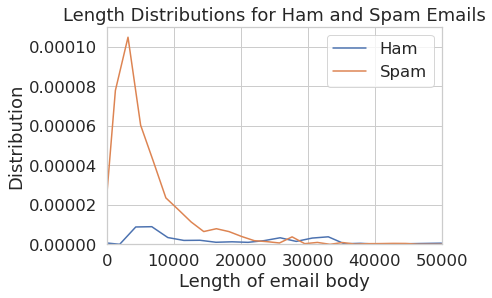

In [8]:
# Getting lengths of each email and attaching the email's label to its length
lengths = train['email'].apply(len)
lengths = pd.DataFrame(data={'lengths': lengths, 'label': train['spam']}).melt('label')
lengths['label'] = lengths['label'].replace(0, 'Ham').replace(1, 'Spam')

hams = lengths[lengths['label'] == 'Ham']
spams = lengths[lengths['label'] == 'Spam']

plt.xlim(0, 50000)
sns.distplot(hams['value'], label='Ham', hist=False)
sns.distplot(spams['value'], label='Spam', hist=False)
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.title('Length Distributions for Ham and Spam Emails');

## Basic Classification

#### For now, only using five words that might be useful as features to distinguish spam/ham emails to create a feature matrix, X_train, with our words_in_text function.

In [9]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

Training a logistic regression model using X_train and Y_train to observe the classifier's accuracy

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7581525356049514


### Evaluating Classifier

#### **Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

#### **Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam.

#### **False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam.

Computing the precision, recall, and false-alarm rate of the logistic regression classifier manually

In [11]:
Y_train_predictions = model.predict(X_train)

TP = np.count_nonzero((Y_train_predictions == Y_train) & (Y_train_predictions == 1))
TN = np.count_nonzero((Y_train_predictions == Y_train) & (Y_train_predictions == 0))
FP = np.count_nonzero((Y_train_predictions != Y_train) & (Y_train_predictions == 1))
FN = np.count_nonzero((Y_train_predictions != Y_train) & (Y_train_predictions == 0))

logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_far = FP / (FP + TN)

print('Precision:', logistic_predictor_precision)
print('Recall:', logistic_predictor_recall)
print('False Alarm Rate:', logistic_predictor_far)

Precision: 0.5926605504587156
Recall: 0.1684045881126173
False Alarm Rate: 0.03967828418230563


A reason why the classifier is performing poorly so far is because X_train has many rows with all 0, meaning that the words currently used are not common among the emails.

## Increasing Accuracy

### More EDA

In [12]:
training = pd.read_csv('../input/email-data/train.csv')
training = training.fillna('')

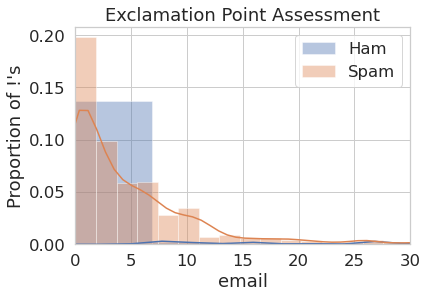

In [13]:
# Proportion of exclamation points
hams = training[training['spam'] == 0]
spams = training[training['spam'] == 1]

ham_punc = hams['email'].str.findall('!').str.len()
spam_punc = spams['email'].str.findall('!').str.len()

sns.distplot(ham_punc, label='Ham')
sns.distplot(spam_punc, label='Spam')
plt.xlim(0, 30)
plt.ylabel("Proportion of !'s")
plt.legend()
plt.title("Exclamation Point Assessment");

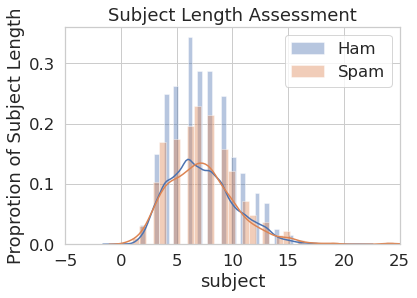

In [14]:
# Number of words in subject
ham_sub_len = hams['subject'].str.findall('\w+').str.len().fillna(0)
spam_sub_len = spams['subject'].str.findall('\w+').str.len().fillna(0)
sns.distplot(ham_sub_len, label='Ham')
sns.distplot(spam_sub_len, label='Spam')
plt.xlim(-5, 25)
plt.ylabel('Proprotion of Subject Length')
plt.title("Subject Length Assessment");
plt.legend();

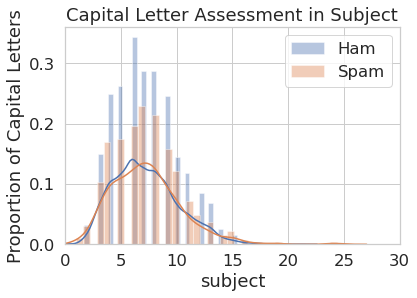

In [15]:
# Number of capital letters in subject
sub_ham_cap = hams['subject'].str.findall('\W+').str.len()
sub_spam_cap = spams['subject'].str.findall('\W+').str.len()
sns.distplot(sub_ham_cap, label='Ham')
sns.distplot(sub_spam_cap, label='Spam')
plt.xlim(0, 30)
plt.ylabel('Proportion of Capital Letters')
plt.title("Capital Letter Assessment in Subject");
plt.legend();

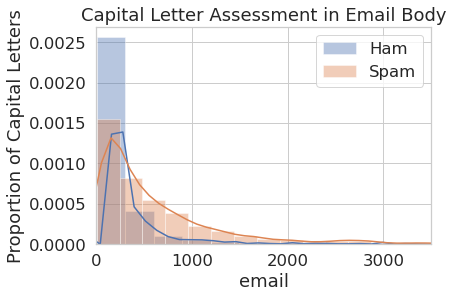

In [16]:
# Number of capital letters in body
ham_cap = hams['email'].str.findall('\W+').str.len()
spam_cap = spams['email'].str.findall('\W+').str.len()
sns.distplot(ham_cap, label='Ham')
sns.distplot(spam_cap, label='Spam')
plt.xlim(0, 3500)
plt.ylabel('Proportion of Capital Letters')
plt.title("Capital Letter Assessment in Email Body");
plt.legend();

Number of Re subjects: 3062
Number of FWD subjects: 4
Number of URL emails: 1333


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  from ipykernel import kernelapp as app


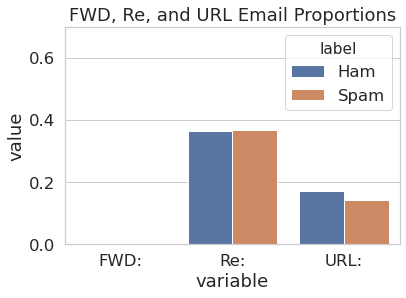

In [17]:
# Reply ('RE:'), FWDs ('FWD:'), and URLs ('URL:')
replies = np.array(training['subject'].str.count("Re:"))
fwds = np.array(training['subject'].str.count("FWD:"))
urls = np.array(training['email'].str.count("URL:"))

print('Number of Re subjects:', sum(training['subject'].str.count('Re:')))
print('Number of FWD subjects:', sum(training['subject'].str.count('FWD:')))
print('Number of URL emails:', sum(training['email'].str.count('URL:')))


# Plotting Re:, FWD:, and URL: for Ham vs Spam emails
df = pd.DataFrame(data={'Re:': replies, 'FWD:': fwds, 'URL:': urls})
df['label'] = Y_train
df['label'] = df['label'].replace(0, 'Ham').replace(1, 'Spam')
df = df.melt('label').groupby(('label', 'variable')).mean().reset_index()

sns.barplot(x=df['variable'], y=df['value'], hue=df['label'])
plt.ylim(0, .7)
plt.title('FWD, Re, and URL Email Proportions');

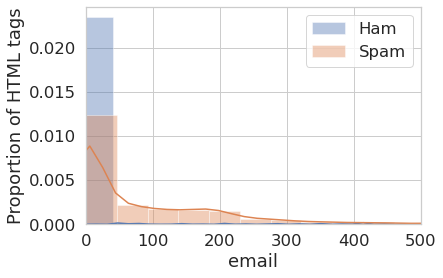

In [18]:
# HTML tags
tag_hams = hams['email'].str.findall('<[^>]*>').str.len()
tag_spams = spams['email'].str.findall('<[^>]*>').str.len()

sns.distplot(tag_hams, label='Ham')
sns.distplot(tag_spams, label='Spam')
plt.xlim(0, 500)
plt.ylabel('Proportion of HTML tags')
plt.legend();

In [19]:
# Finding better words that I initially believe might help distinguishing
some_words = ['body', 'business', 'html', 'money', 'offer', 'please', '$', 'click', 'offer', '<td', '</tr>', '<br']

X_train = words_in_texts(some_words, training['email'])
Y_train = training['spam']

model = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7994729276473407


Because an issue of the classifier is that the words used so far are not used often within the emails, I am finding the most common words and seeing which have significantly different proportions between ham and spam emails.

<Figure size 720x360 with 0 Axes>

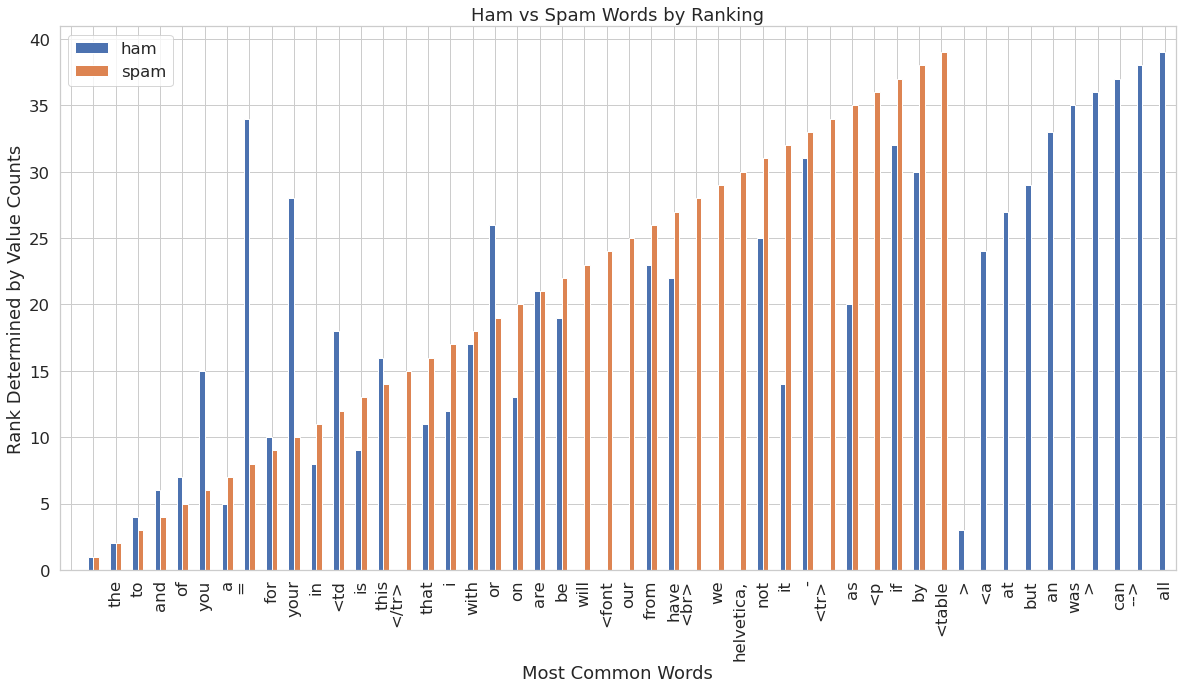

In [20]:
# Finding most common words
ham_emails = original_training_data[original_training_data['spam'] == 0]['email']
spam_emails = original_training_data[original_training_data['spam'] == 1]['email']


# HAMS
ham_dic = {}
for email in ham_emails:
    words = email.split(" ")
    for word in words:
        ham_dic[word] = ham_dic[word] + 1 if (word in ham_dic) else 1
        
ham_word_counts = pd.DataFrame.from_dict(ham_dic, columns = ['count'], orient = 'index')
most_common_ham_words = ham_word_counts.sort_values(by='count', ascending=False)
most_common_ham_words['words'] = most_common_ham_words.index
most_common_ham_words['ham'] = np.arange(len(most_common_ham_words))
most_common_ham_words = most_common_ham_words[:40]


# SPAMS
spam_dic = {}
for email in spam_emails:
    words = email.split(" ")
    for word in words:
        spam_dic[word] = spam_dic[word] + 1 if (word in spam_dic) else 1
        
spam_word_counts = pd.DataFrame.from_dict(spam_dic, columns = ['count'], orient = 'index')
most_common_spam_words = spam_word_counts.sort_values(by='count', ascending=False)
most_common_spam_words['words'] = most_common_spam_words.index
most_common_spam_words['spam'] = np.arange(len(most_common_spam_words))
most_common_spam_words = most_common_spam_words[:40]


# HAMS AND SPAMS
hams_and_spams = pd.merge(most_common_spam_words, most_common_ham_words, how = 'outer', on = 'words')
hams_and_spams = hams_and_spams.rename(columns={'count_x': 'spam_count', 'count_y': 'ham_count'})
hams_and_spams = hams_and_spams[['words', 'spam', 'ham']]


# VISUAL
plt.figure(figsize=(10,5)) 
hams_and_spams.plot.bar(x = 'words', y = ['ham', 'spam'], grid = True, figsize=(20,10), width=.5)
plt.tick_params(axis='both', which='minor', labelsize=6)
plt.xlabel('Most Common Words')
plt.ylabel('Rank Determined by Value Counts')
plt.title('Ham vs Spam Words by Ranking');

## Final Model

In [21]:
lr = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')

# TRAINING
good_words = ['business', 'html', 'money', 'offer', 'please', '<td', 'your', 'you', '!', '$', '%', 'click', 
              'they', 'as', '</tr>', 'faq', 'it', 'can', 'has', '^', 'all', 'on', '<font', '<a', 'from', 
              'not','subscribe', 'unsubscribe', 'credit', 'end soon', '% off', 'cheap', 'buy', 'earn',
              'afford', 'discount', 'free', 'easy', 'claim', 'trial', 'prize', 'win', 'won', 'new', 'sale', 
              'check', 'order', 'limited', 'unlimited', 'visit', 'clearance', 'now','expire', 'member', 
              'cancel', 'cheap', 'dear', 'hello', 'save', 'earn', 'lose', 'profit','auto', 'fast', 'online', 
              '+', 'account', 'book', 'shop', 'check out', 'email','card', 'shipping', 'opportunity', 'bank', 
              'receive', 'dear', 'best', 'deal','help', 'vote', 'spam', 'unsubscribe', 'click', 'signup', 'list',
              '=', 'fax', 'reply', 'credit card', 'im']


replies = np.array(original_training_data['subject'].str.count('Re:'))
fwds = np.array(original_training_data['subject'].str.count('FWD:'))
urls = np.array(original_training_data['subject'].str.count('URL:'))
punc_sub = np.array(original_training_data['subject'].str.findall('!').str.len())
punc_body = np.array(original_training_data['email'].str.findall('!').str.len())
tags = np.array(original_training_data['email'].str.findall('<[^>]*>').str.len())
caps = np.array(original_training_data['subject'].str.findall('\W+').str.len())
date = np.array(original_training_data['email'].str.count("(date:|Date:)"))
com_net = np.array(original_training_data['email'].str.count("(.com|.net|http)"))

X_train = words_in_texts(good_words, original_training_data['email'])
X_train = np.append(X_train, replies[:, None], axis=1)
X_train = np.append(X_train, fwds[:, None], axis=1)
X_train = np.append(X_train, urls[:, None], axis=1)
X_train = np.append(X_train, punc_sub[:, None], axis=1)
X_train = np.append(X_train, punc_body[:, None], axis=1)
X_train = np.append(X_train, tags[:, None], axis=1)
X_train = np.append(X_train, caps[:, None], axis=1)
X_train = np.append(X_train, date[:, None], axis=1)
X_train = np.append(X_train, com_net[:, None], axis=1)


Y_train = original_training_data['spam']
model = lr.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)


# TESTING
test = test.fillna("")
replies_test = np.array(test['subject'].str.count('Re:'))
fwds_test = np.array(test['subject'].str.count('FWD:'))
urls_test = np.array(test['subject'].str.count('URL:'))
punc_sub_test = np.array(test['subject'].str.findall('!').str.len())
punc_body_test = np.array(test['email'].str.findall('!').str.len())
tags_test = np.array(test['email'].str.findall('<[^>]*>').str.len())
caps_test = np.array(test['subject'].str.findall('\W+').str.len())
date_test = np.array(test['email'].str.count("(date:|Date:)"))
com_net_test = np.array(test['email'].str.count("(.com|.net|http)"))

X_test = words_in_texts(good_words, test['email'])
X_test = np.append(X_test, replies_test[:, None], axis=1)
X_test = np.append(X_test, fwds_test[:, None], axis=1)
X_test = np.append(X_test, urls_test[:, None], axis=1)
X_test = np.append(X_test, punc_sub_test[:, None], axis=1)
X_test = np.append(X_test, punc_body_test[:, None], axis=1)
X_test = np.append(X_test, tags_test[:, None], axis=1)
X_test = np.append(X_test, caps_test[:, None], axis=1)
X_test = np.append(X_test, date_test[:, None], axis=1)
X_test = np.append(X_test, com_net_test[:, None], axis=1)


test_predictions = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy:  0.9572352659319597


### The features I ended up using in my final model are helpful words, replies, fwds, urls, exclamation points (subject and email), html tags, capital letters in subject, and if date is provided.**

### Result: 96% accuracy